# Model Comparison on Complex Maze
Here I test out different models to see how many steps it takes them to reach a new terminal state after being trained towards an initial terminal state. I reuse the map 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

import gym_env
from utils import test_agent, get_transition_matrix, create_mapping_nb, woodbury, woodbury_SR
from models import LinearRL, SR_TD

In [2]:
# Set the random seed for NumPy
seed = 32
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
no_goal_env = "maze-10x10-G0"
envs = ["maze-10x10-G1", "maze-10x10-G2", "maze-10x10-G3"]

In [4]:
# Model Hyperparams
reward = -0.8
alpha = 0.05
beta = 1.0
_lambda = 1.0
num_steps = 120000

# Simulation parameters
num_simulations = 5000
new_term_loc = (9,1)
new_term_idx = 61

In [5]:
# Transition matrix with no goal
env = gym.make(no_goal_env)
maze = env.unwrapped.maze
# Get the transition matrix of the new environment
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())
T_no_goal = get_transition_matrix(env, mapping)

### Train DR-TD and SR-TD Agents

In [6]:
# Train DR-TD and SR-TD agents
DR_TD_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
Random_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, num_steps=num_steps, policy="random", imp_samp=False)
DR_Inv_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
SR_wood_agent = LinearRL(env_name=envs[0], reward=reward, term_reward=reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=False)
SR_agent = SR_TD(env_name=envs[0], reward=1,  term_reward=10, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax")

In [7]:
DR_TD_agent.learn(seed=seed)
SR_wood_agent.learn(seed=seed)
SR_agent.learn(seed=seed)

### Update agent's environments & use Woodbury update on DR-TD and DR-Inv

In [8]:
print(new_term_loc)

# Construct a new transition matrix and new environment
T_new = np.copy(T_no_goal)
T_new[new_term_idx] = 0
T_new[new_term_idx, new_term_idx] = 1
new_terminals = np.diag(T_new) == 1
new_target_locs = np.array([list(new_term_loc)])
env_new = env
env_new.unwrapped.target_locs = [np.array((new_term_loc[0], new_term_loc[1]))]

# Update the env of agents
DR_Inv_agent.env = env_new
DR_TD_agent.env = env_new
Random_agent.env = env_new
SR_agent.env = env_new
SR_wood_agent.env = env_new

# Update P
DR_Inv_agent.P = T_new[~new_terminals][:,new_terminals]
DR_TD_agent.P = T_new[~new_terminals][:,new_terminals]
SR_wood_agent.P = T_new[~new_terminals][:,new_terminals]

# Use Woodbury update to get a new DR
DR_td = woodbury(DR_TD_agent, T_new, inv=False)
DR_inv = woodbury(DR_Inv_agent, T_new, inv=True)
SR_new = woodbury(SR_wood_agent, T_new, inv=False)

# Update terminals
DR_Inv_agent.terminals = new_terminals
DR_TD_agent.terminals = new_terminals
SR_wood_agent.terminals = new_terminals

# Set the DR to updated DR for agents and update the values
DR_TD_agent.DR = DR_td
DR_TD_agent.update_V()
DR_Inv_agent.DR = DR_inv
DR_Inv_agent.update_V()
SR_wood_agent.DR = SR_new
SR_wood_agent.update_V()


(9, 1)


### Get average number of steps needed to reach new goal state

In [10]:
DR_inv_avg, DR_td_avg, Random_avg, SR_td_avg, SR_wood_avg = [],[],[],[],[]
for i in range(num_simulations):
    DR_inv_avg.append(len(test_agent(agent=DR_Inv_agent, policy=DR_Inv_agent.policy, seed=seed)))
    DR_td_avg.append(len(test_agent(agent=DR_TD_agent, policy=DR_TD_agent.policy, seed=seed)))
    Random_avg.append(len(test_agent(agent=Random_agent, policy=Random_agent.policy, seed=seed)))
    SR_td_avg.append(len(test_agent(agent=SR_agent, policy=SR_agent.policy, seed=seed)))
    SR_wood_avg.append(len(test_agent(agent=SR_wood_agent, policy=SR_wood_agent.policy, seed=seed)))

In [11]:
print(f"Inverse DR average: {np.mean(DR_inv_avg)}")
print(f"Temporal Difference DR average: {np.mean(DR_td_avg)}")
print(f"Random average: {np.mean(Random_avg)}")
print(f"Temporal Difference SR average: {np.mean(SR_td_avg)}")
print(f"SR Woodbury: {np.mean(SR_wood_avg)}")

Inverse DR average: 18.18
Temporal Difference DR average: 18.68
Random average: 564.452
Temporal Difference SR average: 583.584
SR Woodbury: 26.724


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


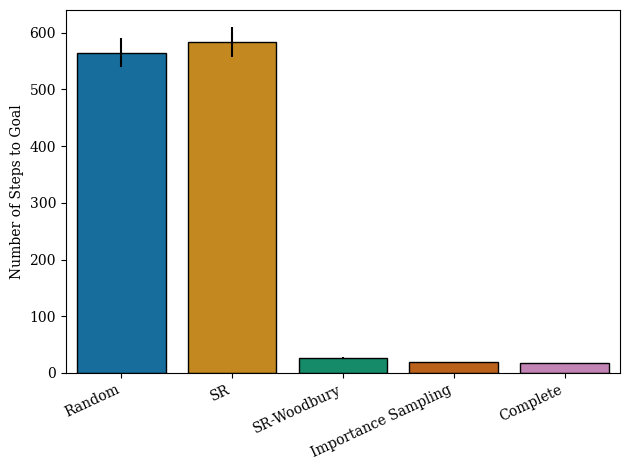

In [14]:
## Plot
save_path = None
# save_path = os.path.join('..', 'figures/') + 'model_comparison.png'

# Prepare the data
categories = ['Random', 'SR', 'SR-Woodbury', 'Importance Sampling', 'Complete']
# categories = ['Random', 'SR', 'Importance Sampling', 'Complete']
data = [Random_avg, SR_td_avg, SR_wood_avg, DR_td_avg, DR_inv_avg]
# data = [Random_avg, SR_td_avg, DR_td_avg, DR_inv_avg]
means = [np.mean(values) for values in data]
sems = [np.std(values) / np.sqrt(len(values)) for values in data]

# Create a color palette
palette = sns.color_palette("colorblind", len(categories))

# Set a nicer font
plt.rcParams['font.family'] = 'serif'

# Create the bar plot
ax = sns.barplot(x=categories, y=means, palette=palette, yerr=sems, capsize=0.2)

# Set the y-axis title
plt.ylabel("Number of Steps to Goal")

# Rotate the x-axis labels if needed
plt.xticks(rotation=25, ha='right')

# Outline the bars in black
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()